# Modeling - First Pass

### Installs, Packages, Seeds

In [71]:
# %pip install efficientnet_pytorch

In [1]:
%pip install torch
# %pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

# python libraties
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns
from itertools import combinations, product

# import imblearn
import logging
from tqdm import tqdm
from glob import glob
from PIL import Image
import ipywidgets

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
# from efficientnet_pytorch import EfficientNet

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# google drive
# from google.colab import drive # Connect colab to google drive

# custom modeling libraries
from build_model import initialize_model, load_split_data, build_loader, evaluate, train_model

# other
import importlib

In [ ]:
# import build_model
# importlib.reload(build_model)

# from build_model import initialize_model, load_split_data, build_loader, evaluate, train_model

# import matplotlib as mpl
# print(mpl.get_cachedir())

## Parameters

In [3]:
model_dict = {'pretrained_model': 'efficientnet',
              'epochs': 3,
              'home_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone',
              'mod_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone/model',
              'csv_name': 'full_data_rename',
              'split': 'split_3',
              'cl': 'label_0',
              'dev_state': False,
              'dev_sample': 15000,
              'seed': 99,
              'lr': .002,
              'batch_size':64,
              'num_workers':24,
              'transform_set':'a',
             }

np.random.seed(model_dict['seed'])
torch.cuda.manual_seed(model_dict['seed'])

# Check GPU
print('GPU Type:', torch.cuda.get_device_name())
print('GPU Count:', torch.cuda.device_count())

GPU Type: Tesla T4
GPU Count: 1


## Data

In [4]:
data, train, test, val = load_split_data(directory = model_dict['home_directory'],
                                         csv_name = model_dict['csv_name'], 
                                         data_split = model_dict['split'], 
                                         label = model_dict['cl'],
                                         mode = 'all',
                                         dev_state = model_dict['dev_state'], 
                                         dev_sample = model_dict['dev_sample'], 
                                         seed = model_dict['seed']
                                         )

## Modeling

In [5]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name = model_dict['pretrained_model'], 
                                        num_classes = len(data.label.unique()),
                                        feature_extract = False, 
                                        use_pretrained=True)

# Define GPU:
device = torch.device('cuda:0')

# Move model to GPU
model = model_ft.to(device)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

After model is defined, add final Parameters

In [26]:
# add some params after model definition
model_dict.update({'model':model,
                   'device':device,
                   'optimizer': optim.SGD(model.parameters(), lr=model_dict['lr']),
                   'criterion': nn.CrossEntropyLoss().to(device),
                   'tuned_model_name':'resnet_split3_3e_Ta',})

In [7]:
transform_header = [
                  transforms.Resize(255),
                  transforms.CenterCrop(224)]

transform_body = [
                  transforms.RandomHorizontalFlip(), # a
                  transforms.RandomVerticalFlip(), # b
                  transforms.RandomRotation(20), # c
                  transforms.RandomCrop(size=(input_size,input_size)), # d
                  transforms.RandomInvert(), transforms.RandomPosterize(bits=2), # e
                  transforms.RandomAdjustSharpness(sharpness_factor=2), # f
                  transforms.RandomSolarize(threshold=192.0), # g
                  transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1) # h
                  ]

transform_footer = [transforms.ToTensor(), 
                  transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])]

In [8]:
transform_list = transform_header + transform_body + transform_footer

In [8]:
# using torch vision 'transforms'
train_transform = transforms.Compose(transform_list)
# define the transformation of the val images. also used for test
val_transform = transforms.Compose([
                                      transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                    ])

In [74]:
tdf['transform'][0]

0

In [68]:
# trans = [0, 1, 2, 3, 4, 5, 6, 7]
# lrs = [.001, .0015, .002, .0025, .003, .0035, .004]
# prods = list(product(trans, lrs))

# trans_num = pd.Series(list(zip(*prods))[0], name = 'transform', dtype = 'int')
# learn_rate = pd.Series(list(zip(*prods))[1], name = 'lr')
# tdf = pd.concat([trans_num, learn_rate], axis = 1)
# tdf['accur'] = pd.Series(dtype = 'float')
# tdf['accur_0'] = pd.Series(dtype = 'float')
# tdf['accur_1'] = pd.Series(dtype = 'float')
# tdf['accur_2'] = pd.Series(dtype = 'float')
# tdf['accur_3'] = pd.Series(dtype = 'float')
# tdf['accur_4'] = pd.Series(dtype = 'float')
# tdf['accur_5'] = pd.Series(dtype = 'float')

In [78]:
# transform_header + [transform_body[tdf['transform'][0]]] + transform_footer

[Resize(size=255, interpolation=bilinear, max_size=None, antialias=None),
 CenterCrop(size=(224, 224)),
 RandomHorizontalFlip(p=0.5),
 ToTensor(),
 Normalize(mean=[0.541, 0.414, 0.382], std=[0.256, 0.215, 0.209])]

### Assemble data loaders

Run the model

In [10]:
HOME = model_dict['home_directory']

In [11]:
cd $HOME

/home/ec2-user/SageMaker/teledermatologyAI_capstone


In [9]:
train_loader = build_loader(mode = 'train', df = train, transform = train_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])
test_loader = build_loader(mode = 'test', df = test, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])
val_loader = build_loader(mode = 'val', df = val, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])

loaders = {'train_loader':train_loader,
                        'val_loader': val_loader,
                        'test_loader': test_loader}
model_dict['loader'] = loaders

## Train Sequence

In [ ]:
train_model(model_dict = model_dict)

Starting Training resnet_split3_3e_Ta
[epoch 1], [iter 100 of 211],[train loss 1.37887], [train acc 0.44266]
[epoch 1], [iter 200 of 211],[train loss 1.26584], [train acc 0.49617]
------------------------------------------------------------
[epoch 1], [val loss 1.09431], [val acc 0.56020]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 3m 10s
best record: [epoch 1], [val loss 1.09431], [val acc 0.56020]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 1.04796], [train acc 0.58156]
[epoch 2], [iter 200 of 211],[train loss 1.01969], [train acc 0.59141]
------------------------------------------------------------
[epoch 2], [val loss 1.00923], [val acc 0.58951]
------------------------------------------------------------

EPOCH 2 :
*****************************************************
Complete in 2m 25s
best record: [epoch 2], [val loss 1.00923], [val acc

## Evaluate

In [14]:
# Label dictionary for evaluation
labels_idx = np.sort(data.label_idx.unique())
label_map = data[['label', 'label_idx']].drop_duplicates().sort_values('label_idx')
label_dict = dict(zip(label_map.label_idx, label_map['label']))

------------------------------------------------------------
[epoch test], [test loss 0.92726], [test acc 0.61961]
------------------------------------------------------------


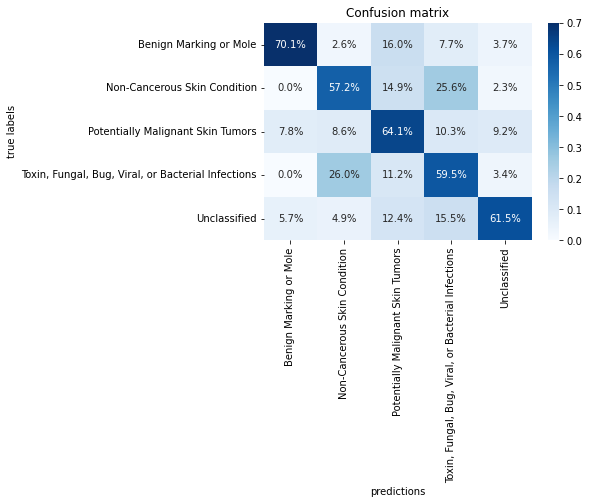

In [15]:
pred_df = evaluate(model_name = model_dict['tuned_model_name'], 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.93283], [test acc 0.62284]
------------------------------------------------------------


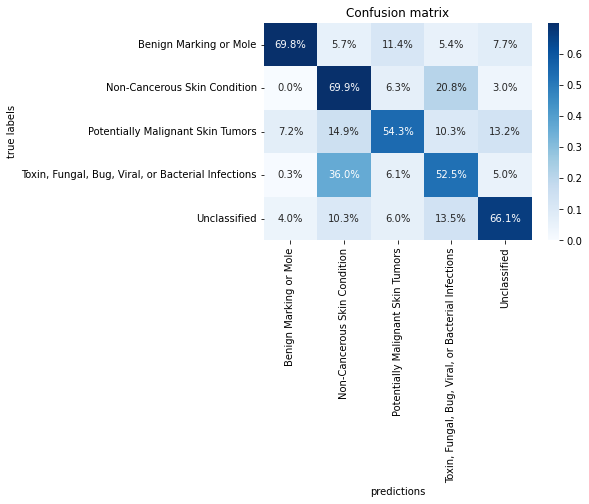

In [14]:
pred_df = evaluate(model_name = model_dict['tuned_model_name'], 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 1.06911], [test acc 0.57328]
------------------------------------------------------------


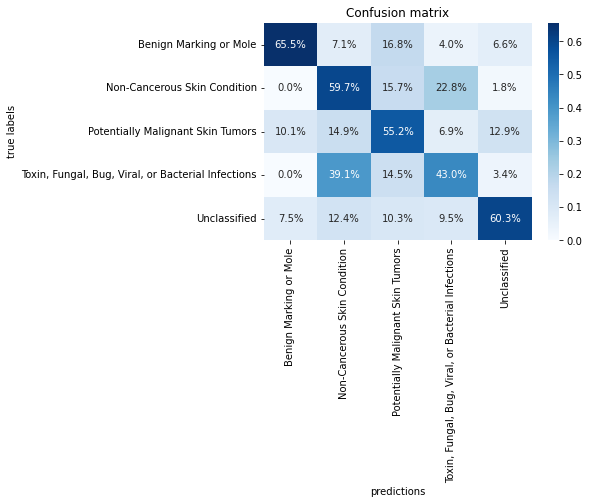

In [85]:
pred_df = evaluate(model_name = model_dict['tuned_model_name'], 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

Write predictions and labels to CSV

In [86]:
direc = model_dict['mod_directory']
nam = model_dict['tuned_model_name']
pred_df.to_pickle(f'{direc}/{nam}_preds.pkl')

In [10]:
d = pd.read_pickle(f'../../model/gridsearch/resnet_split3_3e_GS22_preds.pkl')

In [22]:
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score

In [15]:
d.columns

Index(['lab', 'pred', 'lab_idx', 'pred_idx'], dtype='object')

In [25]:
print(f1_score(d.lab, d.pred, average = 'macro'),
fbeta_score(d.lab, d.pred, average = 'macro', beta = 2),
fbeta_score(d.lab, d.pred, average = 'macro', beta = .5),
precision_score(d.lab, d.pred, average = 'macro'),
recall_score(d.lab, d.pred, average = 'macro'))

0.7404842512723735 0.740237351272228 0.7409286782450882 0.7413372740706109 0.7401801618506285


<module 'sklearn.metrics' from '/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/metrics/__init__.py'>